In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from numpy.linalg import cond, norm, inv
#from scipy.spatial import cKDTree

import pandas as pd
from scipy.stats import linregress as linreg
import scipy.sparse.linalg as spla

import pickle
import os.path
import itertools

# import warnings
# warnings.simplefilter('ignore')

from poly_basis import *
from rbf import *
from spherepts import *
from laplacebeltrami import *

In [2]:
matplotlib.rcParams.update({'font.size': 16})

# Helpers

In [3]:
# look-up
def get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg):
    assert method in ['SWM', 'TPM', 'SOGr']
    assert surface in ['S']
    if surface is 'S':
        assert node_set in ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
    assert poly_type in ['s', 'p']
    
    if method is not 'SWM':
        poly_type = 'n'
    
    file_name  = 'pickles/'
    file_name += method
    file_name += ", " + surface
    file_name += ", " + node_set
    file_name += ", " + str(n)
    file_name += ", " + str(k)
    file_name += ", " + rbf_obj['label']
    file_name += ", " + str(epsilon)
    file_name += ", " + poly_type
    file_name += ", " + str(poly_deg)
    file_name += '.pickle'
    
    if os.path.isfile(file_name):
        f = open(file_name, 'rb')
        C = pickle.load(f)
        f.close()
    else:
        if method is 'SWM':
            C = SWM(nodes, normals, rbf_obj, epsilon, k, poly_deg, poly_type)
        elif method is 'TPM':
            C = TPM(nodes, normals, rbf_obj, epsilon, k, poly_deg)
        elif method is 'SOGr':
            C = SOGr(nodes, normals, rbf_obj, epsilon, k, poly_deg)
        f = open(file_name, 'wb')
        pickle.dump(C, f)
        f.close()
            
    return C

In [4]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

In [5]:
def gen_sphere_nodes(node_set, n_try):
    if node_set == 'spiral':
        n = n_try
        nodes = gen_spiral_nodes(n)
    elif node_set == 'sym_t_design':
        n, nodes = gen_symmetric_t_design_nodes(n_try)
    elif node_set == 'min_energy':
        n, nodes = gen_min_energy_nodes(n_try)
    elif node_set == 'max_det':
        n, nodes = gen_max_det_nodes(n_try)
    elif node_set == 'icos':
        n, nodes = gen_equ_area_icos_nodes(n_try)
    
    return n, nodes

# Testing

In [8]:
method = 'SOGr'
surface = 'S'
n = 2000
k = 50
rbf_obj = rbf_dict['multiquadric']
epsilon = None
poly_type = 'p'
poly_deg = 4

foo, exact = get_exact('gaussians')

node_set = 'spiral'
nodes = gen_spiral_nodes(n)
normals = nodes



C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg)
print(C.todense())

epsilon set: 0.449692
[[-966.31462975  234.78981497  282.85995526 ...    0.
     0.            0.        ]
 [ 263.42058094 -921.96449049   67.78524141 ...    0.
     0.            0.        ]
 [ 260.97474229   49.61914079 -885.88659314 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -887.85808179
    49.32901434  262.83248469]
 [   0.            0.            0.         ...   67.29254897
  -921.34859727  263.53130351]
 [   0.            0.            0.         ...  282.28009203
   233.20829765 -964.14364828]]


In [9]:
fs = np.array([foo(node) for node in nodes])
ds = np.array([exact(node) for node in nodes])
print(np.max(np.abs(C@fs - ds)))

0.0011402789044385464


In [60]:
spla.eigs(C, k=1, which='LR')[0][0]

(-1.3633089867255706e-10+0j)

# Parameters

In [6]:
surface = 'S'

methods = ['SWM', 'TPM', 'SOGr']
# methods = ['SWM']

#node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
node_sets = ['spiral']

# ns = [1600* 2**i for i in range(0,4)]
# ns = [100 * 2**i for i in range(6)]
ns = [800]

stencil_sizes = [10 * 2**i for i in range(7)] #+ [800]
# stencil_sizes = [50, 200]

rbfs = ['multiquadric', 'r^9']
# rbfs = ['multiquadric']
# rbfs = ['r^9']

epsilons = [None]
#epsilons = [1, .5, .25, .1, .05]

basis_degs = [-1, 0, 1, 2, 3] # -1 for no terms
# basis_degs = [2]
# basis_degs = range(-1, 5)
#basis_degs = range(-1,2) # -1 for no terms
basis_types = ['p']
# basis_types = ['p']

foo, exact = get_exact('gaussians')
# foo, exact = get_exact(10)

eig_calc = True


# calculate_weights_cond = False
# calculate_stencil_conds = True
# calc_largest_real_eig = True 


# Print Specs
sep = 22
print('Methods:'.ljust(sep)            + ', '.join(methods))
print('Surface:'.ljust(sep)            + surface)
print('Node sets:'.ljust(sep)          + ', '.join(node_sets))
print('Total Nodes:'.ljust(sep)        + ', '.join([str(n) for n in ns]))
print('Stencil Sizes:'.ljust(sep)      + ', '.join([str(k) for k in stencil_sizes]))
print('RBFs:'.ljust(sep)               + ', '.join(rbfs))
print('Epsilons:'.ljust(sep)           + ', '.join([str(e) for e in epsilons]) )
print('Polynomial Bases:'.ljust(sep)   + ', '.join(basis_types))
print('Polynomial Degrees:'.ljust(sep) + ', '.join([str(d) for d in basis_degs]))

trials = 1
trials *= len(methods)
trials *= len(node_sets)
trials *= len(ns)
trials *= len(stencil_sizes)
trials *= len(rbfs)
trials *= len(epsilons)
trials *= len(basis_types)
trials *= len(basis_degs)

print('\nTrials to run: %d' % trials)

Methods:              SWM, TPM, SOGr
Surface:              S
Node sets:            spiral
Total Nodes:          800
Stencil Sizes:        10, 20, 40, 80, 160, 320, 640
RBFs:                 multiquadric, r^9
Epsilons:             None
Polynomial Bases:     p
Polynomial Degrees:   -1, 0, 1, 2, 3

Trials to run: 210


# Generate Data

In [7]:
columns = ['surface', 'nodeset', 'N', 'k', 'method', 'rbf', 'epsilon', 'poly_type', 'deg',
           'rel_L2_error', 'max_error', 'Re_eig']
data = pd.DataFrame(columns=columns)

for node_set, n in itertools.product(node_sets, ns):
    print('\n' + node_set + ' n=' + str(n))
    if surface is 'S':
        n_try = n
        n, nodes = gen_sphere_nodes(node_set, n_try)
        normals = nodes
    fs = np.array([foo(node) for node in nodes])
    ds = np.array([exact(node) for node in nodes])
#     tree = cKDTree(np.array(nodes))
    for k, rbf in itertools.product(stencil_sizes, rbfs):
        print(('\t' + rbf.ljust(14)) + 'k=' + str(k).rjust(4))
        rbf_obj = rbf_dict[rbf]
        
        for method in methods:
            for poly_type, poly_deg in itertools.product(basis_types, basis_degs):
                if method is 'TPM' and poly_type is 's': continue
                print('\t    ' + method +'  ' + poly_type + '  d=' + str(poly_deg).rjust(2))
                for eps in epsilons:
                    if rbf_obj['shape']:
                        print('\t\t epsilon = %s' % str(eps))
                    ##################################################
                    # calculate weights and errors
                    ##############################
                    if poly_deg is -1:
                        poly_deg = None
                    try:
#                     if True:
                        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                                    eps, poly_type, poly_deg)
                        rel_error_L2  = la.norm(C@fs - ds)/la.norm(ds)
                        rel_error_max = np.max(np.abs(C@fs - ds))/np.max(np.abs(ds))
                        print('\t\t  relative L2  error: %g' % rel_error_L2)
                        print('\t\t  relative Max error: %g' % rel_error_max)
                        if eig_calc:
                            eig = spla.eigs(C, k=1, which='LR')[0][0].real
                        else:
                            eig = None
                        data = data.append( 
                            {'method': method, 'surface': surface,
                             'nodeset': node_set, 'rbf':rbf, 'epsilon': eps,
                             'deg': str(poly_deg), 'poly_type' : poly_type,
                             'N':n, 'k':k,
                             'max_error': rel_error_max, 
                             'rel_L2_error': rel_error_L2,
                             'Re_eig' : eig,
                             }, ignore_index=True)
                    except:
                        print('\t\t  Failed...')
                    
                    
                    ##################################################
                    # end calculate weights and errors
                    ##################################################
                    if not rbf_obj['shape']: break
    


spiral n=800
	multiquadric  k=  10
	    SWM  p  d=-1
		 epsilon = None
		  relative L2  error: 0.0257849
		  relative Max error: 0.0209307
	    SWM  p  d= 0
		 epsilon = None
		  relative L2  error: 0.0257832
		  relative Max error: 0.0209305
	    SWM  p  d= 1
		 epsilon = None
		  relative L2  error: 0.0259821
		  relative Max error: 0.0209628
	    SWM  p  d= 2
		 epsilon = None
		  relative L2  error: 0.0644299
		  relative Max error: 0.243235
	    SWM  p  d= 3
		 epsilon = None
		  relative L2  error: 2.2995e+09
		  relative Max error: 7.74468e+09
	    TPM  p  d=-1
		 epsilon = None
		  relative L2  error: 0.0189617
		  relative Max error: 0.0244886
	    TPM  p  d= 0
		 epsilon = None
		  relative L2  error: 0.0193588
		  relative Max error: 0.0258946
	    TPM  p  d= 1
		 epsilon = None
		  relative L2  error: 0.019537
		  relative Max error: 0.0260765
	    TPM  p  d= 2
		 epsilon = None
		  relative L2  error: 0.0187796
		  relative Max error: 0.0238317
	    TPM  p  d= 3
		 epsilo

	    SWM  p  d= 1
		 epsilon = None
		  relative L2  error: 0.000288222
		  relative Max error: 0.000219244
	    SWM  p  d= 2
		 epsilon = None
		  relative L2  error: 0.000296107
		  relative Max error: 0.000239309
	    SWM  p  d= 3
		 epsilon = None
		  relative L2  error: 0.000291028
		  relative Max error: 0.000245545
	    TPM  p  d=-1
		 epsilon = None
		  relative L2  error: 0.0002313
		  relative Max error: 0.000221322
	    TPM  p  d= 0
		 epsilon = None
		  relative L2  error: 0.000232645
		  relative Max error: 0.000220847
	    TPM  p  d= 1
		 epsilon = None
		  relative L2  error: 0.00023139
		  relative Max error: 0.000214648
	    TPM  p  d= 2
		 epsilon = None
		  relative L2  error: 0.000211718
		  relative Max error: 0.000193342
	    TPM  p  d= 3
		 epsilon = None
		  relative L2  error: 0.000195026
		  relative Max error: 0.000166972
	    SOGr  p  d=-1
		 epsilon = None
		  relative L2  error: 9.89022e-05
		  relative Max error: 8.82392e-05
	    SOGr  p  d= 0
		 epsilon 

	    TPM  p  d= 3
		  relative L2  error: 0.00462481
		  relative Max error: 0.00378715
	    SOGr  p  d=-1
		  relative L2  error: 7740.57
		  relative Max error: 15187.8
	    SOGr  p  d= 0
		  relative L2  error: 1986.61
		  relative Max error: 3619.16
	    SOGr  p  d= 1
		  relative L2  error: 5.31338e+15
		  relative Max error: 2.42539e+16
	    SOGr  p  d= 2
		  relative L2  error: 8150.87
		  relative Max error: 24525.5
	    SOGr  p  d= 3
		  relative L2  error: 3.82062e+07
		  relative Max error: 1.45934e+08
	multiquadric  k= 640
	    SWM  p  d=-1
		 epsilon = None
		  relative L2  error: 7.16691e-06
		  relative Max error: 7.701e-06
	    SWM  p  d= 0
		 epsilon = None
		  relative L2  error: 7.15623e-06
		  relative Max error: 7.71335e-06
	    SWM  p  d= 1
		 epsilon = None
		  relative L2  error: 7.17028e-06
		  relative Max error: 7.71069e-06
	    SWM  p  d= 2
		 epsilon = None
		  relative L2  error: 7.24357e-06
		  relative Max error: 7.74279e-06
	    SWM  p  d= 3
		 epsilon 

# Raw Data

In [8]:
if len(data)<20:
    display(data)
elif len(data)< 100:
    display(data[::7])
elif len(data)< 500:
    display(data[::11])
elif len(data)<1000:
    display(data[::51])
else:
    display(data[:5000:100])

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
0,S,spiral,800,10,SWM,multiquadric,None,p,None,2.578487e-02,2.093075e-02,-4.217920e-06
11,S,spiral,800,10,SOGr,multiquadric,None,p,1,1.782940e-02,1.514484e-02,-3.108624e-15
22,S,spiral,800,10,SOGr,r^9,None,p,0,5.346753e+17,2.187714e+18,1.350341e+19
33,S,spiral,800,20,TPM,multiquadric,None,p,2,1.075279e-03,1.152457e-03,-2.872144e-15
44,S,spiral,800,20,TPM,r^9,None,p,None,3.115810e+02,6.916405e+02,7.645900e+03
55,S,spiral,800,40,SWM,multiquadric,None,p,0,5.040125e-04,3.890256e-04,-5.684342e-14
66,S,spiral,800,40,SOGr,multiquadric,None,p,2,1.883240e-04,1.287810e-04,-5.906386e-14
77,S,spiral,800,40,SOGr,r^9,None,p,None,1.654839e+13,7.436846e+13,4.987509e+14
88,S,spiral,800,80,TPM,multiquadric,None,p,0,2.326451e-04,2.208471e-04,1.932240e-14
99,S,spiral,800,80,SWM,r^9,None,p,1,8.131679e-04,7.374468e-04,8.508333e-13


In [80]:
my_data = data[(data.method=='SWM') & (data.rbf=='r^9')]
display(my_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
3,S,spiral,100,50,SWM,r^9,None,p,2,0.122685,2.554740,1.433287e-13
4,S,spiral,100,50,SWM,r^9,None,s,2,0.122685,2.554740,8.908315e-15
9,S,spiral,200,50,SWM,r^9,None,p,2,0.021647,0.379995,3.028059e-13
10,S,spiral,200,50,SWM,r^9,None,s,2,0.021647,0.379995,7.273739e-14
15,S,spiral,400,50,SWM,r^9,None,p,2,34.993947,2158.137251,9.762728e+04
16,S,spiral,400,50,SWM,r^9,None,s,2,34.993950,2158.137419,9.762728e+04
21,S,spiral,800,50,SWM,r^9,None,p,2,0.001562,0.028865,-5.139624e-12
22,S,spiral,800,50,SWM,r^9,None,s,2,0.001562,0.028865,-1.126623e-14
27,S,spiral,1600,50,SWM,r^9,None,p,2,0.000944,0.027381,-3.229788e-11
28,S,spiral,1600,50,SWM,r^9,None,s,2,0.000944,0.027381,-3.468708e-12


In [81]:
print(my_data.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>surface</th>
      <th>nodeset</th>
      <th>N</th>
      <th>k</th>
      <th>method</th>
      <th>rbf</th>
      <th>epsilon</th>
      <th>poly_type</th>
      <th>deg</th>
      <th>rel_L2_error</th>
      <th>max_error</th>
      <th>Re_eig</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>3</th>
      <td>S</td>
      <td>spiral</td>
      <td>100</td>
      <td>50</td>
      <td>SWM</td>
      <td>r^9</td>
      <td>None</td>
      <td>p</td>
      <td>2</td>
      <td>0.122685</td>
      <td>2.554740</td>
      <td>1.433287e-13</td>
    </tr>
    <tr>
      <th>4</th>
      <td>S</td>
      <td>spiral</td>
      <td>100</td>
      <td>50</td>
      <td>SWM</td>
      <td>r^9</td>
      <td>None</td>
      <td>s</td>
      <td>2</td>
      <td>0.122685</td>
      <td>2.554740</td>
      <td>8.908315e-15</td>
    </tr>
    <tr>
      <th>9</th>
      <td>S</td>
    

# Plots

### By Degree - (Method, RBF, polytype, k)

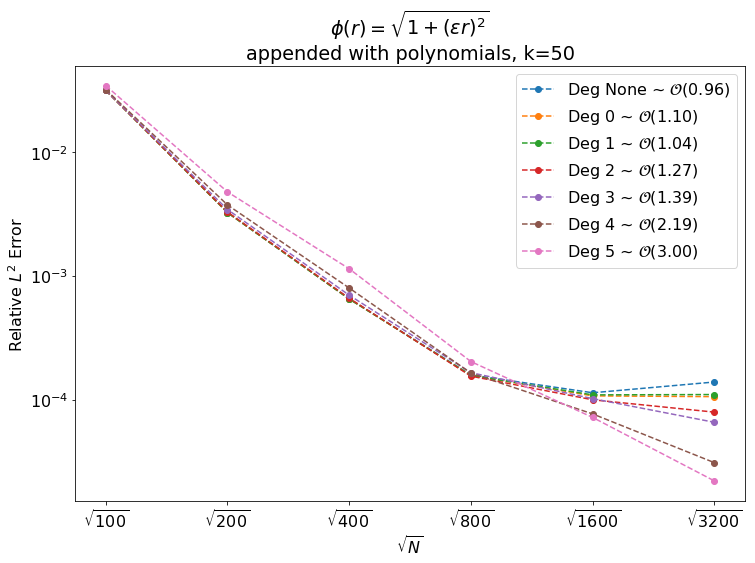

In [19]:
rbf = 'multiquadric'
method = 'SOGr'
poly_type = 'p'
k = 50

# Order calculation terms
o_start = 3
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
if method is 'SWM':
    title += 'Shankar-Wright Method using '
elif method is 'TPM':
    title += 'Tangent Plane Method using '
rbf_obj = rbf_dict[rbf]
title += '$\phi(r)=$' + rbf_obj['tex']
if poly_type is 'p':
    title += '\nappended with polynomials, '
else:
    title += '\nappended with spherical harmonics, '
title += ('k=%d' % k)

my_data = data[(data.method==method) & (data.rbf==rbf) & (data.poly_type==poly_type)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, deg in enumerate(my_data.deg.unique()):
    plot_data = my_data[my_data.deg==str(deg)]
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
               plot_data.rel_L2_error, marker='o', linestyle='dashed')
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += ['Deg ' + deg + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Method - (RBF, d, k)

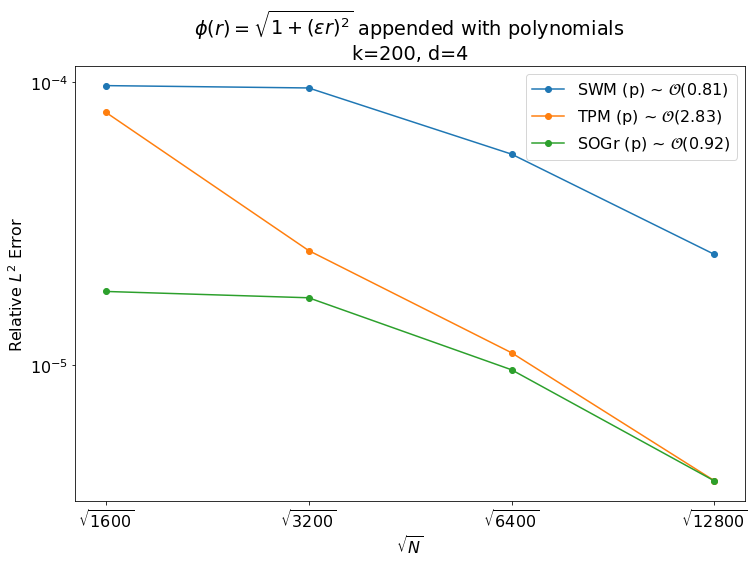

In [47]:
rbf = 'multiquadric'
d = '4'
k = 200

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.rbf==rbf) & (data.k==k)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, method in enumerate(my_data.method.unique()):
    for poly_type, linestyle, marker in zip('ps', ['-','--'], 'ox'):
        plot_data = my_data[(my_data.method==method) & (my_data.poly_type==poly_type)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Stencil Size

ValueError: Inputs must not be empty.

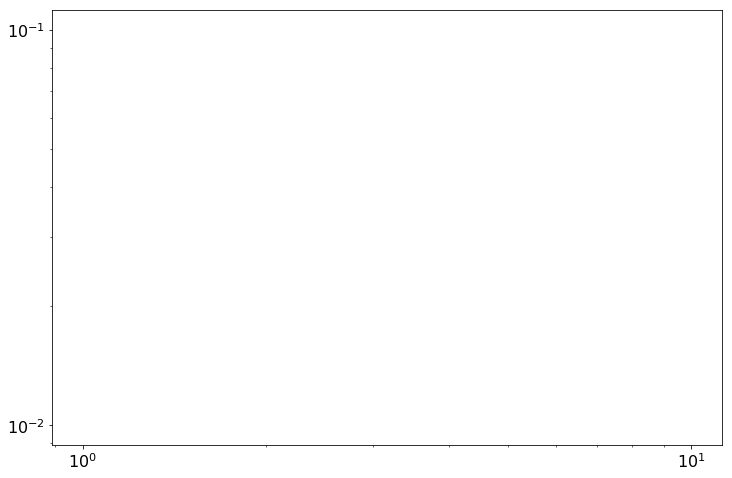

In [17]:
method = 'SOGr'
rbf = 'multiquadric'
d = '2'

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.rbf==rbf) & (data.method==method)]
fig = plt.figure(figsize=(12,8))
legend = []
for k in my_data.k.unique():
    plot_data = my_data[(my_data.k==k)]
    if len(plot_data)<1: continue
    plt.loglog( np.sqrt(plot_data.k.astype(np.float)), 
               plot_data.rel_L2_error)
    order = linreg(np.log(np.sqrt(plot_data.k[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [18]:
display(my_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
12,S,spiral,800,10,SOGr,multiquadric,None,p,2,0.018075,0.015248,2.842171e-14
38,S,spiral,800,20,SOGr,multiquadric,None,p,2,0.001112,0.001200,-2.109424e-14
66,S,spiral,800,40,SOGr,multiquadric,None,p,2,0.000188,0.000129,-5.906386e-14
95,S,spiral,800,80,SOGr,multiquadric,None,p,2,0.000096,0.000082,2.637211e-13
125,S,spiral,800,160,SOGr,multiquadric,None,p,2,0.000035,0.000027,5.725167e-14
155,S,spiral,800,320,SOGr,multiquadric,None,p,2,0.000008,0.000006,5.207674e-14
185,S,spiral,800,640,SOGr,multiquadric,None,p,2,0.000002,0.000002,-2.700184e-14


### Mixing Methods and Rbfs

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
0,S,spiral,1600,50,SWM,multiquadric,None,p,None,0.000261,0.000181,-5.034726e-05
1,S,spiral,1600,50,SWM,multiquadric,None,p,0,0.000231,0.000185,3.605425e-13
2,S,spiral,1600,50,SWM,multiquadric,None,p,1,0.000237,0.000196,1.023626e-12
3,S,spiral,1600,50,SWM,multiquadric,None,p,2,0.000234,0.000186,1.217385e-14
4,S,spiral,1600,50,SWM,multiquadric,None,p,3,0.000215,0.000192,-1.707361e-12
5,S,spiral,1600,50,SWM,multiquadric,None,p,4,0.000158,0.000139,-1.481110e-11
6,S,spiral,1600,50,TPM,multiquadric,None,p,None,0.000126,0.000103,-3.412607e-05
7,S,spiral,1600,50,TPM,multiquadric,None,p,0,0.000120,0.000114,-9.221965e-14
8,S,spiral,1600,50,TPM,multiquadric,None,p,1,0.000120,0.000110,-1.412688e-14
9,S,spiral,1600,50,TPM,multiquadric,None,p,2,0.000112,0.000091,-3.736313e-15


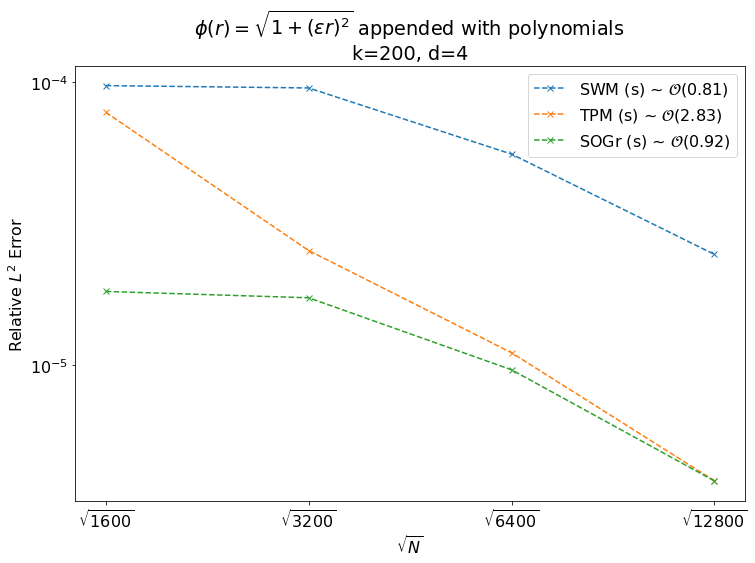

In [57]:
rbf = 'multiquadric'
d = '4'
k = 200

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.k==k)]
display(data)
fig = plt.figure(figsize=(12,8))
legend = []
for method in my_data.method.unique():
    for rbf in my_data.rbf.unique():
        plot_data = my_data[(my_data.method==method) & (my_data.rbf==rbf)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [54]:
display(my_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
23,S,spiral,1600,200,SWM,multiquadric,None,p,4,0.000097,0.000083,-5.056425e-12
29,S,spiral,1600,200,TPM,multiquadric,None,p,4,0.000078,0.000073,-1.785964e-14
35,S,spiral,1600,200,SOGr,multiquadric,None,p,4,0.000018,0.000016,-3.739238e-13
59,S,spiral,3200,200,SWM,multiquadric,None,p,4,0.000096,0.000091,-4.036219e-13
65,S,spiral,3200,200,TPM,multiquadric,None,p,4,0.000025,0.000022,-4.312587e-15
71,S,spiral,3200,200,SOGr,multiquadric,None,p,4,0.000017,0.000020,-6.655170e-13
95,S,spiral,6400,200,SWM,multiquadric,None,p,4,0.000056,0.000099,5.604881e-12
101,S,spiral,6400,200,TPM,multiquadric,None,p,4,0.000011,0.000011,2.392240e-13
107,S,spiral,6400,200,SOGr,multiquadric,None,p,4,0.000010,0.000015,-2.096101e-13
130,S,spiral,12800,200,SWM,multiquadric,None,p,4,0.000025,0.000033,-1.063363e-10


# Eigenvalue Plots

In [24]:
param = 'method'

methods = ['SWM', 'TPM', 'SOGr']
poly_degs = [None, 0, 1, 3, 4]
rbf_labels = ['r^9', 'multiquadric', 'gaussian']
ks = [10*2**i for i in range(1,5)]

# Defaults

method = 'TPM'
surface = 'S'
node_set = 'spiral'
n = 3200
k = 50
rbf_obj = rbf_dict['multiquadric']
epsilon = None
poly_type = 'p'
poly_deg = 4

######################################################

n, nodes = gen_sphere_nodes(node_set, n)
normals = nodes
Cs = []
legend = []

if param is 'deg':
    title = 'Eigenvalues for n=%d, k=%d\n' % (n, k)
    if method is 'SWM':
        title += 'Shankar-Wright Method, '
    elif method is 'TPM':
        title += 'Tangent Plane Method, '
    title += '$\phi(r)=$' + rbf_obj['tex']
    for poly_deg in poly_degs:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += ['deg = ' + str(poly_deg)]
        
elif param is 'method':
    title = 'Eigenvalues for n=%d, k=%d, d=%s\n' % (n, k, str(poly_deg))
    title += '$\phi(r)=$' + rbf_obj['tex']
    for method in methods:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += [method]

elif param is 'rbf':
    title = 'Eigenvalues for n=%d, k=%d, d=%s\n' % (n, k, str(poly_deg))
    if method is 'SWM':
        title += 'Shankar-Wright Method'
    elif method is 'TPM':
        title += 'Tangent Plane Method'
    for rbf_label in rbf_labels:
        rbf_obj = rbf_dict[rbf_label]
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += [rbf_obj['tex']]
        
elif param is 'k':
    title = 'Eigenvalues for n=%d, d=%s\n' % (n, str(poly_deg))
    if method is 'SWM':
        title += 'Shankar-Wright Method, '
    elif method is 'TPM':
        title += 'Tangent Plane Method, '
    title += '$\phi(r)=$' + rbf_obj['tex']
    for k in ks:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += ['k = ' + str(k)]

In [25]:
for C1, C2 in itertools.combinations(Cs, r=2):
    print(np.max(np.abs(C1-C2)))
eigs = [la.eig(C.todense())[0] for C in Cs]

270.91962007515235
383.63407870706124
123.34730051108454


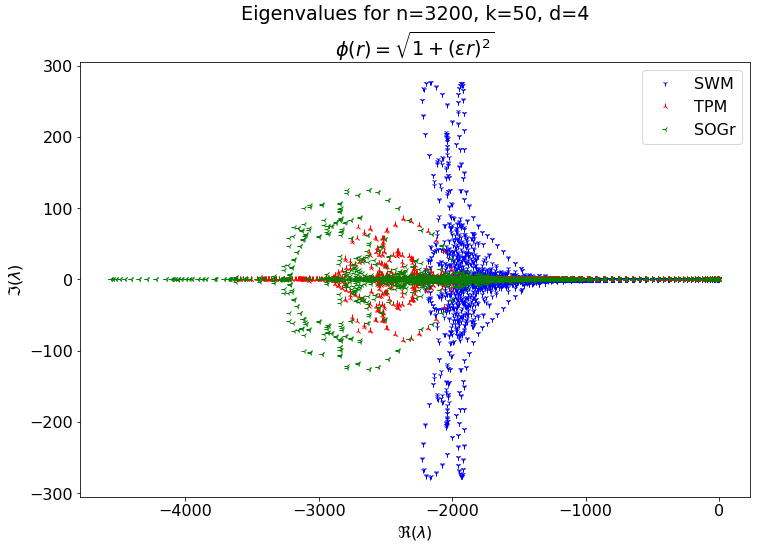

In [26]:
styles = ['b1', 'r2', 'g3', 'k4', 'yx', 'm^', 'cv']
fig = plt.figure(figsize=(12,8))
for eig, style in zip(eigs, styles):
    plt.plot(eig.real, eig.imag, style)
    
plt.legend(legend)
    
plt.title(title)
# plt.minorticks_off()
plt.xlabel('$\Re(\lambda)$')
plt.ylabel('$\Im(\lambda)$')
plt.show()

# Saved Runs